In [122]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

In [123]:
## Adeesh data from the perspecive paper
df_val = pd.read_csv("gemnet-relaxations.csv", index_col=0)
df_val["error"] = np.abs(df_val["energy dE [eV]"] - df_val["genmet_T_predE"])
# sort error column in descending order
df_val.sort_values(by=['error'], inplace=True, ascending=False)

In [124]:
## pick the 100 nonmetallic systems with the highest ML errors
df_nonmetals = df_val.query("material_type == 'nonmetals'")
sids = df_nonmetals.iloc[:101]["ID"].values

In [125]:
## load the mappings stored from previous experiments
with open('dft_settings_study_mappings.pkl', 'rb') as read_file:
    updated_mappings = pickle.load(read_file)
df_full = pd.DataFrame(updated_mappings).transpose()
# make a dataframe from the mappings and query for the system of choice
df_full.rename(columns={'class': 'cat_class'}, inplace=True)

In [128]:
def unconverged_scf(df):
    uuids = df.index.values
    results = {}
    for uuid in tqdm(uuids):
        max_nelm = df.loc[uuid]["max_nelm"]
        nelm = df.loc[uuid]["nelm"]
        last_scf_cycle_dE = df.loc[uuid]["last_scf_cycle_dE"]
        try: 
            if (np.abs(last_scf_cycle_dE)>0.0001) & (nelm==max_nelm):
                results[uuid] = last_scf_cycle_dE
        except:
            # if nelm==max_nelm:
            results[uuid] = last_scf_cycle_dE
    return results

## ENCUT convergence

In [129]:
# remove unfinished calculations
df = df_full.query("final_energy.isnull()==False")
# get only encut calcualtions
df = df.query("sigma==0.2&k_point_multiplier==40")

In [130]:
# check for scf convergence
results = unconverged_scf(df)
# get the sid for the systems that even have a single calc not converged to remove from the analysis
unconv = list(df.loc[list(results.keys())].oc20_sid.values)
# remove the unconverged systems
df = df.query(f"oc20_sid != {unconv}")

100%|██████████| 1029/1029 [00:00<00:00, 9499.28it/s]


In [131]:
def energy_encut_conv(df,encut_values, material):
    all_final_energies = {}
    for sid in tqdm(np.unique(df.oc20_sid)):
        try: 
            df_sid = df.query(f"oc20_sid == '{sid}'") 
            final_energies = [] 
            for encut in encut_values: 
                final_energies.append(df_sid.query(f"encut=={encut}")['final_energy'].values[0])
            all_final_energies[sid] = final_energies
            plt.plot(encut_values, np.array(final_energies) - final_energies[-1], "-o",)
        except IndexError as exception:
            pass
#             print(f"{sid} has some unfinshed calculations")
    plt.title(f"{material} energy convergence vs encut")       
    plt.xlabel("encut (ev)")
    plt.ylabel("Energy convergence error (ev)");
    return all_final_energies

100%|██████████| 81/81 [00:00<00:00, 126.40it/s]


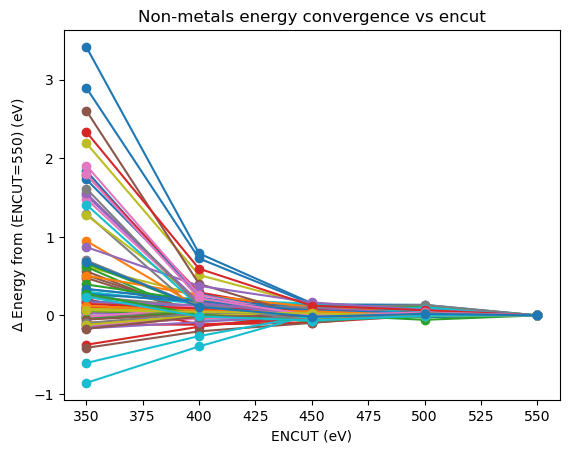

In [132]:
worst_nonmetals_df_adslab= df.query(f"oc20_sid=={list(sids)}")
nonmetals_energy_encut = energy_encut_conv(worst_nonmetals_df_adslab,
                                          encut_values=[350,400,450,500,550],material="Non-metals")
plt.xlabel("ENCUT (eV)")
plt.ylabel("$\Delta$ Energy from (ENCUT=550) (eV)");

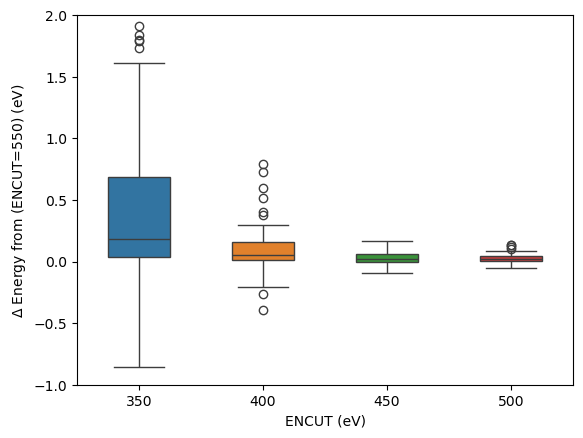

In [133]:
new_fig = np.array(list(nonmetals_energy_encut.values()))-np.array(list(nonmetals_energy_encut.values()))[:,-1].reshape(-1,1)
new_fig_df = pd.DataFrame({"350":new_fig[:,0],
                          "400":new_fig[:,1],
                          "450":new_fig[:,2],
                          "500":new_fig[:,3],})
sns.boxplot(data = new_fig_df ,widths=0.5)
plt.xlabel("ENCUT (eV)")
plt.ylabel("$\Delta$ Energy from (ENCUT=550) (eV)")
plt.ylim((-1,2));

## KPOINTS Convergence

In [134]:
# remove unfinished calculations
df = df_full.query("final_energy.isnull()==False")
# get only encut calcualtions
df = df.query("sigma==0.2&encut==350&frame_num=='initial'&k_point_multiplier==[40,80]")

In [135]:
# check for scf convergence
results = unconverged_scf(df)
# get the sid for the systems that even have a single calc not converged to remove from the analysis
unconv = list(df.loc[list(results.keys())].oc20_sid.values)
# remove the unconverged systems
df = df.query(f"oc20_sid != {unconv}")

100%|██████████| 323/323 [00:00<00:00, 9742.34it/s]


In [136]:
def kpt_convergence(df,kpts_values, material):
    all_final_energies = []
    for sid in tqdm(np.unique(df.oc20_sid)):
        try: 
            df_sid = df.query(f"oc20_sid == '{sid}'") 
            final_energies = [] 
            for kpt in kpts_values: 
                final_energies.append(df_sid.query(f"k_point_multiplier=={kpt}")['final_energy'].values[0])
            all_final_energies.append(final_energies)
            plt.plot(kpts_values, 
                     np.array(final_energies) - final_energies[-1], "-o",)
        except IndexError as exception:
            pass
#             print(f"{sid} has some unfinshed calculations")
    plt.title(f"{material} convergence vs k-points")       
    plt.xlabel("K-point multiplier")
    plt.ylabel("Energy convergence error (ev)");
    return np.array(all_final_energies) 

  0%|          | 0/89 [00:00<?, ?it/s]

100%|██████████| 89/89 [00:00<00:00, 238.95it/s]


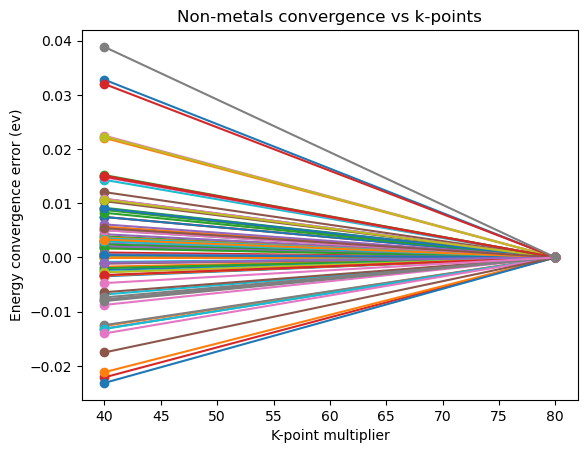

In [137]:
worst_nonmetals_df_adslab= df.query(f"oc20_sid=={list(sids)}")
kpts_df = worst_nonmetals_df_adslab.query("ads_symbols.isnull()==False&oc20_sid.isnull()==False")
nonmetals_kpt = kpt_convergence(kpts_df,kpts_values=[40,80],material="Non-metals")

## Cancellation of Errors

In [138]:
with open("mapping_adslab_slab.pkl", "rb") as input_file:
    slab_adslab_mappings = pickle.load(input_file)

In [146]:
## pick the 11 nonmetallic systems with the highest ML errors
df_nonmetals = df_val.query("material_type == 'nonmetals'")
sids = list(df_nonmetals.iloc[:11]["ID"].values)
## remove the calculations 
sids.remove('random2567526')
sids.remove('random842728')
slab_sids = [slab_adslab_mappings[sid] for sid in sids]

In [147]:
adslab_df = df.query(f"oc20_sid=={list(sids)}&ads_symbols.isnull()==False")

In [149]:
slab_df = df.query(f"oc20_sid=={list(slab_sids)}&ads_symbols.isnull()==True").drop_duplicates(subset=["oc20_sid","k_point_multiplier"])

In [158]:
all_energy_diff = []
for sid in sids:
    slab_sid = slab_adslab_mappings[sid]
    energy_difference = []
    for kpts in [40,80]: 
        adslab_energy = adslab_df.query(f"oc20_sid == '{sid}'&k_point_multiplier=={kpts}")['final_energy'].values[0]
        slab_energy = slab_df.query(f"oc20_sid == '{slab_sid}'&k_point_multiplier=={kpts}")['final_energy'].values[0]
        energy_difference.append(adslab_energy- slab_energy)
    all_energy_diff.append(energy_difference)


In [163]:
all_energy_diff = np.array(all_energy_diff)
np.mean(np.abs(all_energy_diff[:,0] - all_energy_diff[:,1])), np.max(np.abs(all_energy_diff[:,0] - all_energy_diff[:,1]))

(0.005650562222235244, 0.018256919999885213)

In [ ]:
def slab_adslab_Econv(slabs_df, adslabs_df, encut_values, material):
    ## (adslab - slab) convergence results
    all_energy_differences = []
    for sid in tqdm(np.unique(adslabs_df.oc20_sid)):
        try:
            slab_df = slabs_df.query(f"updated_sid == '{sid}'")
            adslab_df = adslabs_df.query(f"oc20_sid == '{sid}'") 
            energy_differences = []
            for encut in encut_values : 
                # get the energy of the slab 
                slab_final_energy = slab_df.query(f"encut=={encut}")['final_energy'].values[0]
                ## get the energy of the adslab
                adslab_final_energy = adslab_df.query(f"encut=={encut}")['final_energy'].values[0]
                energy_differences.append(adslab_final_energy - slab_final_energy)
            all_energy_differences.append(energy_differences)
            plt.plot(encut_values, 
                     np.array(energy_differences) - energy_differences[-1], "-o",)
        except IndexError as exception:
            pass
    plt.title(f"{material} (adslab - slab) convergence vs encut")       
    plt.xlabel("encut (ev)")
    plt.ylabel("Energy convergence error (ev)");
    return np.array(all_energy_differences)

## SIGMA Convergence

In [15]:
# remove unfinished calculations
df = df_full.query("final_energy.isnull()==False")
# get only sigma calcualtions
df = df.query("encut==350&k_point_multiplier==40&max_nelm==60&frame_num=='initial'")

In [16]:
results = unconverged_scf(df)
# get the sid for the systems that even have a single calc not converged to remove from the analysis
unconv = list(df.loc[list(results.keys())].oc20_sid.values)
# remove the unconverged systems
df = df.query(f"oc20_sid != {unconv}")

100%|██████████| 606/606 [00:00<00:00, 9747.31it/s]


In [17]:
def sigma_Econv(df, sigma_values, material):
    all_final_energies = []
    for sid in tqdm(np.unique(df.oc20_sid)):
        try: 
            df_sid = df.query(f"oc20_sid == '{sid}'") 
            final_energies = [] 
            for sig in sigma_values : 
                final_energies.append(df_sid.query(f"sigma=={sig}")['final_energy'].values[0])
            all_final_energies.append(final_energies)
            plt.plot(sigma_values, 
                     np.array(final_energies) - final_energies[-1], "-o",) 
        except IndexError as exception:
            pass
    plt.title(f"{material} convergence vs sigma")       
    plt.xlabel("sigma")
    plt.ylabel("Energy convergence error (ev)");
    return np.array(all_final_energies)

100%|██████████| 70/70 [00:00<00:00, 107.51it/s]


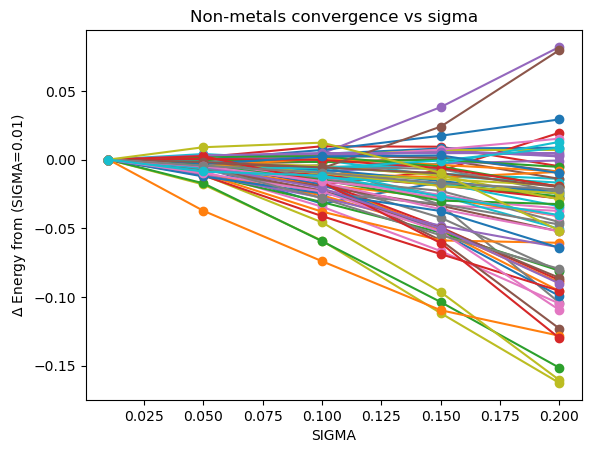

In [18]:
worst_nonmetals_df_adslab= df.query(f"oc20_sid=={list(sids)}")
nonmetals_energy_sigma = sigma_Econv(worst_nonmetals_df_adslab,sigma_values=[0.2,0.15,0.1,0.05,0.01]
                                  ,material="Non-metals")
plt.xlabel("SIGMA")
plt.ylabel("$\Delta$ Energy from (SIGMA=0.01)");

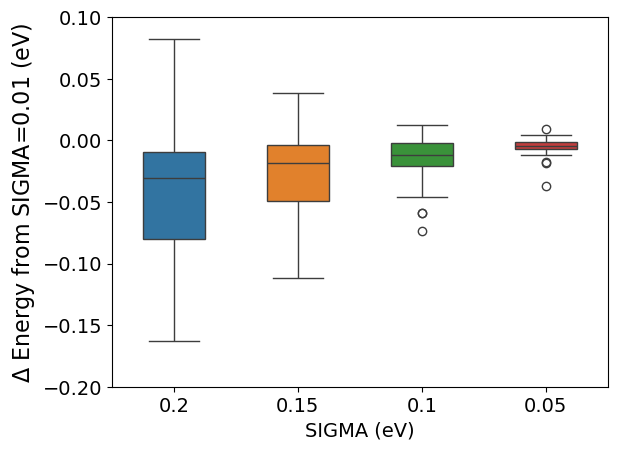

In [19]:
new_fig = nonmetals_energy_sigma-nonmetals_energy_sigma[:,-1].reshape(-1,1)
new_fig_df = pd.DataFrame({"0.2":new_fig[:,0],
                          "0.15":new_fig[:,1],
                          "0.1":new_fig[:,2],
                          "0.05":new_fig[:,3],
                          })
ax = sns.boxplot(data = new_fig_df ,widths=0.5)
ax.set_ylim((-0.2,0.1))
plt.xlabel("SIGMA (eV)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("$\Delta$ Energy from SIGMA=0.01 (eV)", fontsize=16);